In [1]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 

import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk
from astropy.io import fits
from skimage.morphology import skeletonize
from skimage import io
import csv
import Metric

In [2]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)

<module 'ImageAnalysis' from 'c:\\Users\\HP\\Documents\\JHU_Academics\\Research\\PHANGS\\PHANGSDustFill\\ImageAnalysis.py'>

In [9]:
# Specify the path to your FITS file
fits_file = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\JWST_F770W_filamentenhanced_multiscale_examples (1)\Users\dthilker\python\Constrained-Diffusion-Decomposition-main\ngc4321_770_CDDss0064pc_arcsinh0p1_sato.fits'

# Load the FITS file data
hdul = fits.open(fits_file)
image_data = hdul[0].data  # Assuming the image data is in the primary HDU

# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

(2391, 2548)


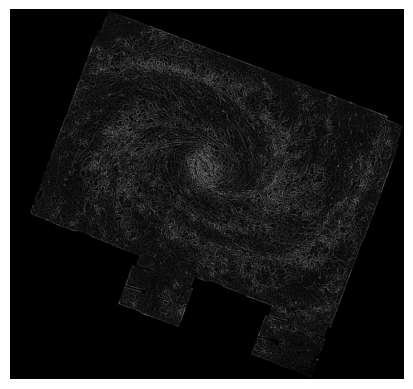

In [24]:

cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Original.png', image_data)

# Display the image using Matplotlib without axes and colorbar
plt.imshow(image_data, cmap='gray')  # Adjust cmap if your data is not grayscale
print(np.shape(image_data))
plt.axis('off')  # Turn off axes

# Close the FITS file
hdul.close()





(-0.5, 2547.5, 2390.5, -0.5)

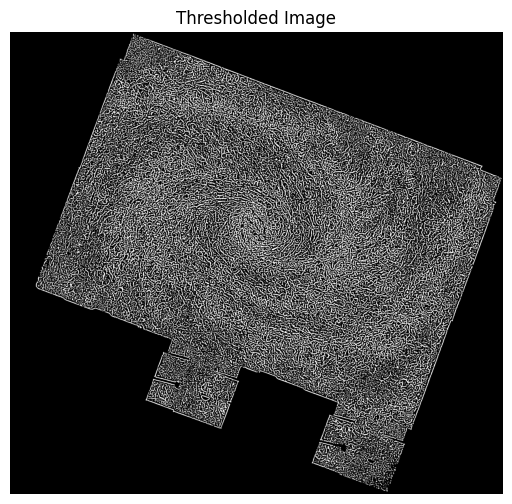

In [50]:
# Load the FITS file
fits_file = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\JWST_F770W_filamentenhanced_multiscale_examples (1)\Users\dthilker\python\Constrained-Diffusion-Decomposition-main\ngc4321_770_CDDss0064pc_arcsinh0p1_sato.fits'
hdul = fits.open(fits_file)
image_data = hdul[0].data
hdul.close()

# Convert the FITS image data to 8-bit format if necessary
# Normalize data to the range [0, 255]
image_data = 255 * (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
image_data = image_data.astype(np.uint8)

total_thresh = cv2.adaptiveThreshold(image_data, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -5)

cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png', total_thresh)

# Display the results
plt.figure(figsize=(8, 6))

plt.title('Thresholded Image')
plt.imshow(total_thresh, cmap='gray')
plt.axis('off')


C:\Users\HP\AppData\Local\Temp\ipykernel_63168\2203433381.py:8: UserWarning: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png', skeleton)


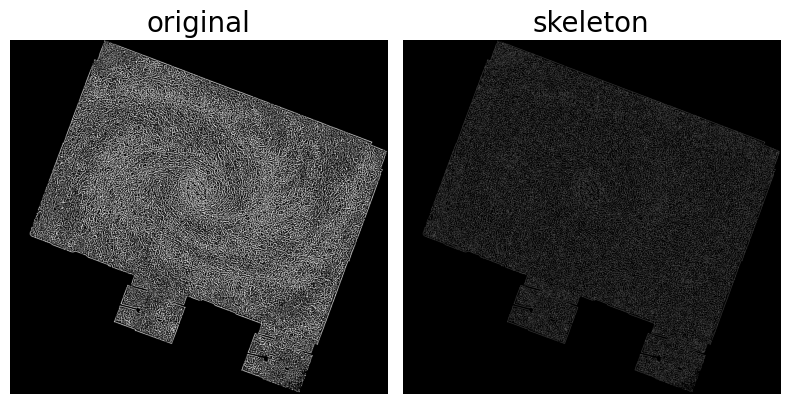

In [51]:
# Assuming th2 is the image to be skeletonized
image = total_thresh

# Perform skeletonization
skeleton = skeletonize(image)

# Save the skeletonized image
io.imsave(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png', skeleton)

# Display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()


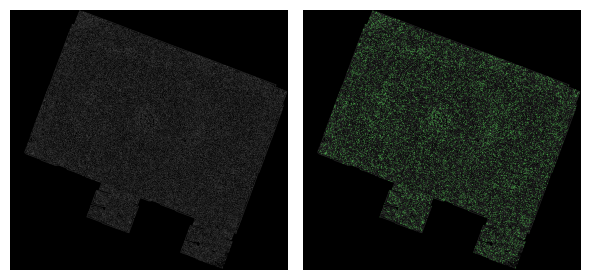

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\thresholdintersectsremoved.png


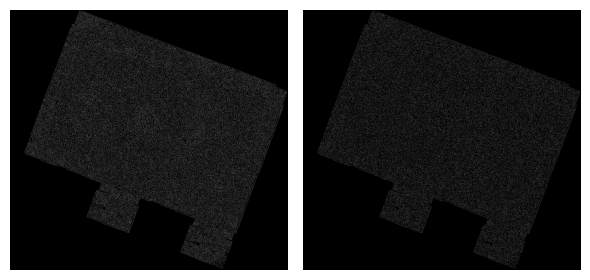

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\thresholdintersectsremoved.png


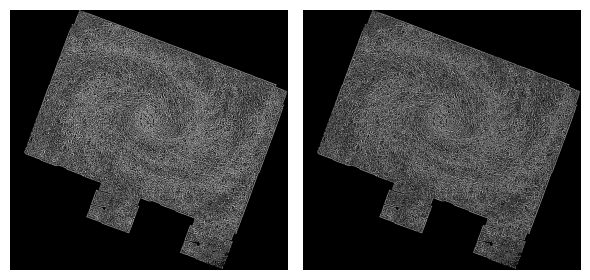

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\thresholdintersectsremoved.png


In [52]:
importlib.reload(IA)
path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png'

skeleton_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def neighbours(x, y, image):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    img = image
    x_1, y_1, x1, y1 = x - 1, y - 1, x + 1, y + 1
    return [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]]

def getSkeletonIntersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.
    
    Keyword arguments:
    skeleton -- the skeletonised image to detect the intersections of
    
    Returns: 
    List of 2-tuples (x,y) containing the intersection coordinates
    """
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    image = skeleton.copy() / 255
    intersections = []
    for x in range(1, len(image) - 1):
        for y in range(1, len(image[x]) - 1):
            # If we have a white pixel
            if image[x][y] == 1:
                neighbors = neighbours(x, y, image)
                if neighbors in validIntersection:
                    intersections.append((y, x))
    
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    filtered_intersections = []
    for point1 in intersections:
        add_point = True
        for point2 in filtered_intersections:
            if ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2:
                add_point = False
                break
        if add_point:
            filtered_intersections.append(point1)
    
    return filtered_intersections

def draw_intersections(image_path, intersections, output_path):
    # Load the original image
    image = cv2.imread(image_path)
    
    # Check if the image was loaded properly
    if image is None:
        raise ValueError("Image not loaded. Check the file path and ensure the file exists.")
    
    # Create an overlay image with transparency
    overlay = image.copy()
    alpha = 0.6  # Transparency factor

    for (x, y) in intersections:
        # Draw a green circle on the overlay image
        cv2.circle(overlay, (x, y), 5, (0, 255, 0), -1)
    
    # Combine the original image with the overlay
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    
    # Save the output image
    cv2.imwrite(output_path, image)
    
    # Display the result
    cv2.imshow("Intersections", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# File paths
skeleton_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png'
output_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\intersections_flagged.png'

# Load the skeletonized image
skeleton_image = cv2.imread(skeleton_image_path, cv2.IMREAD_GRAYSCALE)

# Find the intersections
intersections = getSkeletonIntersection(skeleton_image)

# Draw intersections on the original image
draw_intersections(skeleton_image_path, intersections, output_image_path)

intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImageNoIntersects.png'

IA.remove_junctions(intersections, skeleton_image_path, intersects_removed, dot_size = 2)

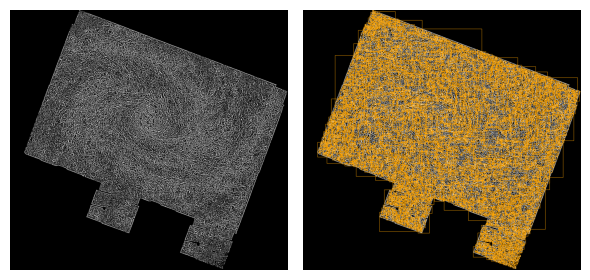

In [53]:
importlib.reload(IA)
labels, stats, num_labels = IA.identify_connected_components(intersects_removed)

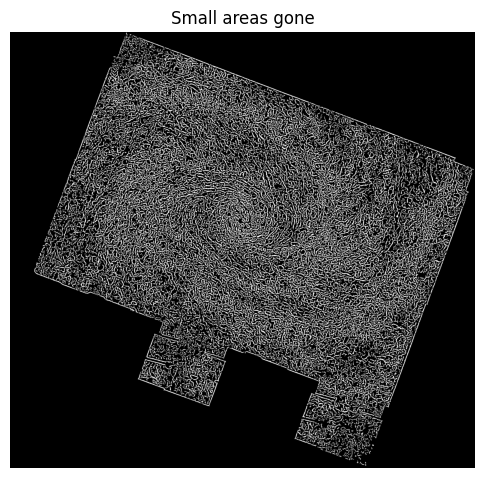

True

In [55]:
importlib.reload(IA)
small_areas = IA.sort_label_id(num_labels, stats, 50)
img = cv2.imread(intersects_removed, cv2.IMREAD_GRAYSCALE)  # Read as grayscale image

for label_id in small_areas:
    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    for x in range(width):
        for y in range(height):
            img[top:top+height, left:left+width] = 0


# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)

# Display the thresholded image (optional)
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axes
plt.title('Small areas gone')
plt.show()


cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png', img)
    

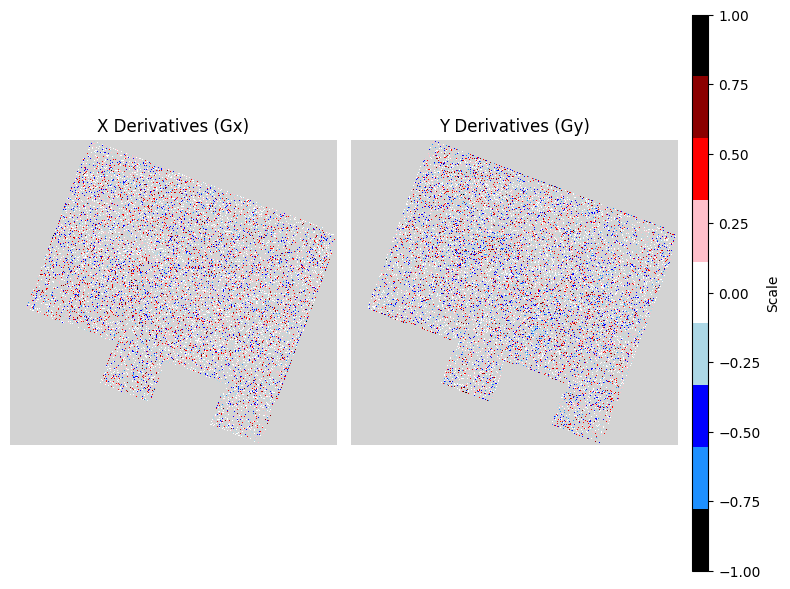

In [56]:
# read the image
importlib.reload(IA)
importlib.reload(PF)
# img = cv2.imread(intersects_removed)

# # convert to gray
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # blur
# blur = cv2.GaussianBlur(gray, (0,0), 1.3, 1.3)
# # apply sobel derivatives
# sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=3)
# sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=3)
# PF.plot_sobel_derivatives(sobelx, sobely)

filtered_input = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png'
#filtered_input = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\thresholdwithintersects.png'

sobel_x, sobel_y = IA.apply_sobel_filter_to_components(filtered_input, labels, stats, num_labels)

PF.plot_sobel_derivatives(filtered_input,sobel_x, sobel_y)



c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:100: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:100: RuntimeWarning: invalid value encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:85: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


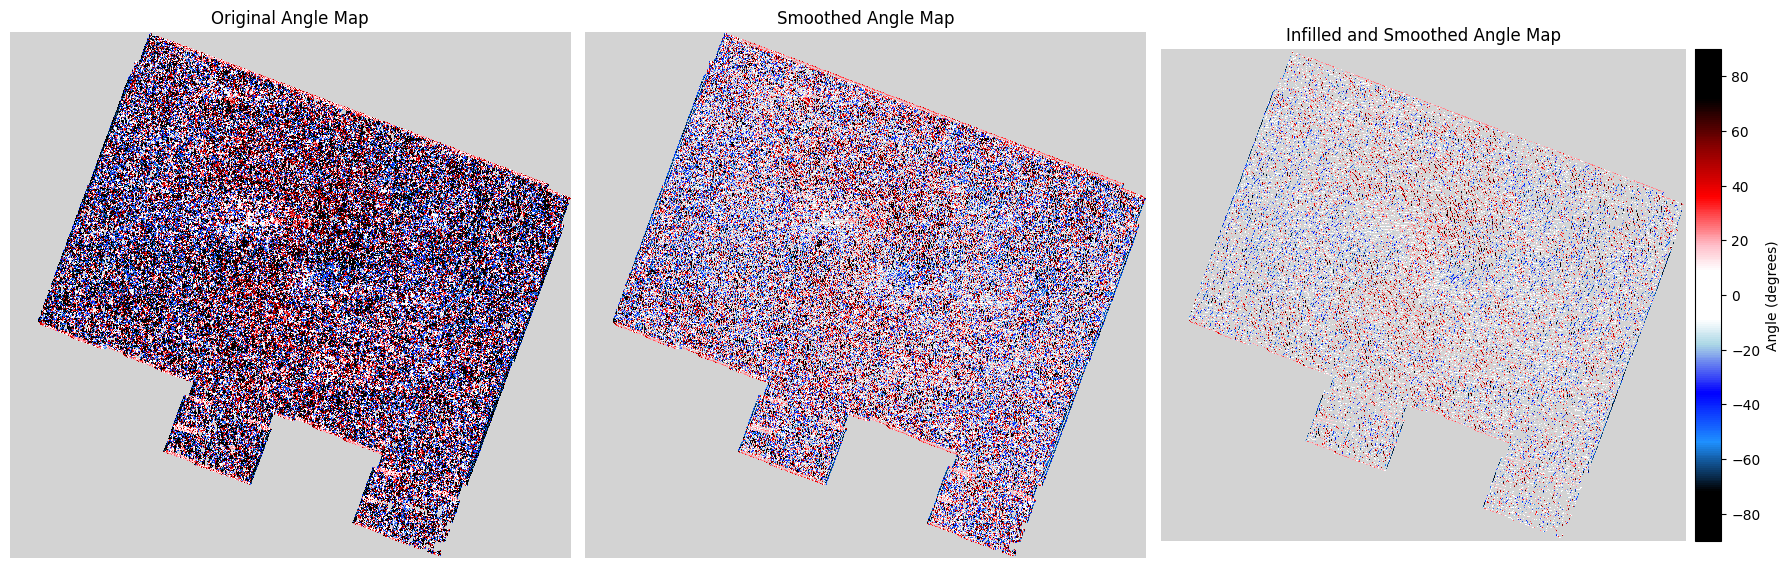

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [57]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'

mask_path = filtered_input

smoother_angle_map, smoothed_angled_map = PF.plot_arctan_with_smoothing(sobel_y, sobel_x, mask_path, 3, smoothed_angles)

(238, 254, 3)


(-0.5, 253.5, 237.5, -0.5)

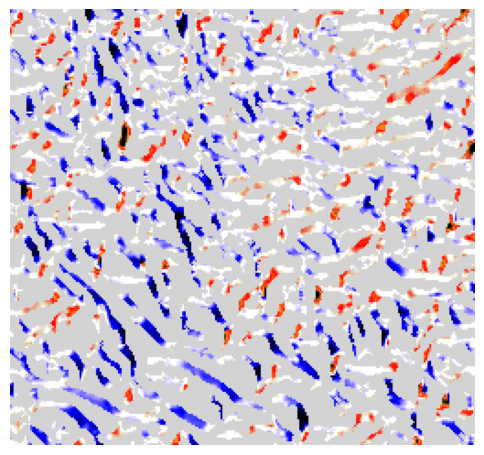

In [58]:
# Define the zoomed-in region

img = cv2.imread(smoothed_angles, cv2.IMREAD_COLOR)  # Read as color image
img = np.array(img)

zoom_factor = 0.1  # Zoom factor (adjust as needed)
image_center_x, image_center_y = np.shape(img)[1] // 2, np.shape(img)[0] // 2  # Center of the image
zoom_width = int(np.shape(img)[1]* zoom_factor)
zoom_height = int(np.shape(img)[0] * zoom_factor)
x_start = image_center_x - zoom_width // 2
x_end = image_center_x + zoom_width // 2
y_start = image_center_y - zoom_height // 2
y_end = image_center_y + zoom_height // 2

# Display the zoomed-in image using Matplotlib without axes and colorbar

# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)

plt.imshow(img[y_start:y_end, x_start:x_end], cmap='gray')  # Adjust cmap if your data is not grayscale
print(np.shape(img[y_start:y_end, x_start:x_end]))
plt.axis('off')  # Turn off axes


Number of hexagons: 1558
0.9944498925057792 0.26845303418691574


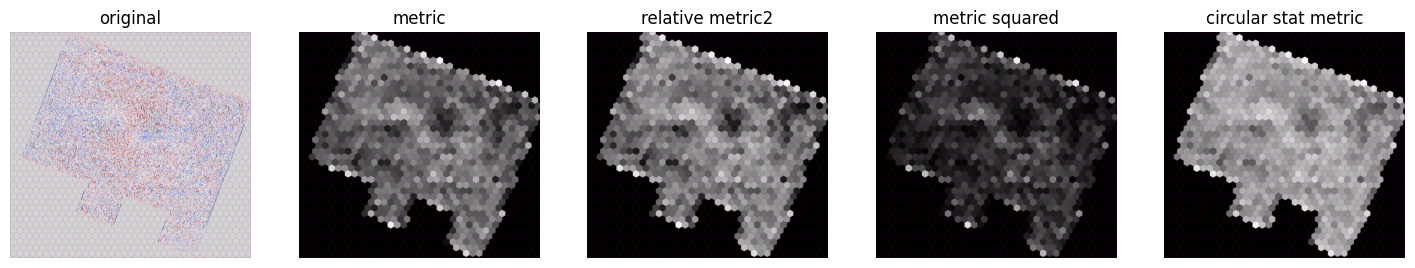

In [68]:

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)
import pandas as pd 

# Paths and image loading
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
img = cv2.imread(original_image_path, cv2.COLOR_BGR2RGB)

# Hexagon settings
hexagon_size = 40
hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(original_image_path, hexagon_size)
hexagon_centers = [x[0] for x in hexagons]
hexagon_corners = [x[1] for x in hexagons]

hex_dict = {}

# Process each hexagon
for i in range(len(hexagon_corners)):
    mask = myGUI.get_hexagon_mask(img.shape, hexagon_corners[i])
    data_in_hexagon = smoother_angle_map[mask == 255]
    data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]
    if len(data_in_hexagon) > 100 and np.mean(data_in_hexagon) != 0:
        hex_dict[hexagon_centers[i]] = (Metric.compute_my_metric(data_in_hexagon), len(data_in_hexagon), Metric.alignment_metric(data_in_hexagon))
    else:
        hex_dict[hexagon_centers[i]] = (np.nan, np.nan, np.nan)
print(f'Number of hexagons: {len(hexagon_centers)}')

# Create a new image to draw the hexagons filled with the alignment metric colors
hexagon_image1 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image2 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image3 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image4 = Image.new("RGB", (img.shape[1], img.shape[0]))

draw1 = ImageDraw.Draw(hexagon_image1)
draw2 = ImageDraw.Draw(hexagon_image2)
draw3 = ImageDraw.Draw(hexagon_image3)
draw4 = ImageDraw.Draw(hexagon_image4)


count = 0

# Save hex_dict to CSV
csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Hexagon Center', 'Number of Pixels', 'Alignment Metric', 'Adjusted Metric', 'Metric Squared', 'metric2'])
    # Extract the first elements from each tuple
    metrics = [info[0] for info in hex_dict.values() if not np.isnan(info[0])]
    metrics_2 = [info[2] for info in hex_dict.values() if not np.isnan(info[2])]

    # Calculate the max and min values of the first elements
    max_metric = max(metrics_2)
    min_metric = min(metrics_2)
    print(max_metric,min_metric)
    for center, info in hex_dict.items():
        metric = info[0]
        number_of_pixels = info[1]
        metric_2 = info[2]
        adjusted_metric = (metric_2 - min_metric)/(max_metric-min_metric)
        metric_squared= metric**2
        writer.writerow([center, number_of_pixels, metric, adjusted_metric, metric_squared, metric_2])
        if not np.isnan(metric) and not np.isnan(adjusted_metric):
            grayscale_value1 = int(metric *255)  # Map to grayscale (0 to 255)
            grayscale_value2 = int(adjusted_metric*255)
            grayscale_value3 = int(metric_squared*255)
            grayscale_value4 = int(metric_2*255)
            corners = hexagon_corners[count]
            draw1.polygon(corners, fill=(grayscale_value1, grayscale_value1, grayscale_value1), outline="purple")
            draw2.polygon(corners, fill=(grayscale_value2, grayscale_value2, grayscale_value2), outline="purple")
            draw3.polygon(corners, fill=(grayscale_value3, grayscale_value3, grayscale_value3), outline="purple")
            draw4.polygon(corners, fill=(grayscale_value4, grayscale_value4, grayscale_value4), outline="purple")
        else:
            corners = hexagon_corners[count]
            draw1.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw2.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw3.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw4.polygon(corners, fill=(0, 0, 0), outline="purple")
        count += 1


# Display the original and processed images
fig, ax = plt.subplots(1, 5, figsize=(18, 18))  # Adjust the figsize as needed

ax[0].imshow(hexagon_image_og)
ax[0].set_title('original')
ax[0].axis('off')  # Hide axes if you want to only show the image

ax[1].imshow(hexagon_image1, cmap='gray')  # Assuming hexagon_image1 is grayscale
ax[1].set_title('metric')
ax[1].axis('off')  # Hide axes if you want to only show the image

ax[2].imshow(hexagon_image2, cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[2].set_title('relative metric2')
ax[2].axis('off')  # Hide axes if you want to only show the image

ax[3].imshow(hexagon_image3, cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[3].set_title('metric squared')
ax[3].axis('off')  # Hide axes if you want to only show the image

ax[4].imshow(hexagon_image4, cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[4].set_title('circular stat metric')
ax[4].axis('off')  # Hide axes if you want to only show the image

plt.show()

In [69]:
importlib.reload(myGUI)
importlib.reload(Metric)
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
data_array = smoother_angle_map
myGUI.run_hexagon_analysis(original_image_path, csv_path, data_array,  hexagon_size)